In [1]:
import sys
from pathlib import Path

# Add parent directory to Python path
parent_dir = Path('.').absolute().parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))

In [2]:
import os
import pandas as pd
import torch
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
)

from datasets import Dataset, DatasetDict, Audio

DATASET_DIR = "../datasets"
DATASET_PATH = os.path.join(DATASET_DIR, "combined__case_sensitive_part1.csv")
SEED = 137

OUTPUT_DIR = "../outputs/part1"
PROCESSED_DATASET_DIR = os.path.abspath(os.path.join(OUTPUT_DIR, "processed_uzbek_asr_dataset"))
LOGS_DIR = os.path.abspath(os.path.join(OUTPUT_DIR, "logs"))
MODEL_CHECKPOINTS_PATH = os.path.abspath(os.path.join(OUTPUT_DIR, "whisper-uzbek-small"))
FINAL_MODEL_PATH = os.path.abspath(os.path.join(OUTPUT_DIR, "whisper-uzbek-final"))

MODEL_NAME = "openai/whisper-small"

In [3]:
import psutil

# Get virtual memory statistics
mem = psutil.virtual_memory()

print(f"Total System Memory (RAM): {mem.total / (1024 ** 3):.2f} GB")
print(f"Available:                 {mem.available / (1024 ** 3):.2f} GB")
print(f"Used:                      {mem.used / (1024 ** 3):.2f} GB")
print(f"Percentage:                {mem.percent}%")

# Check CUDA availability
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"✓ GPU available: {torch.cuda.get_device_name(device)}")
    print(f"✓ GPU memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.2f} GB")

    # Check available memory
    print(f"✓ Memory allocated: {torch.cuda.memory_allocated(device) / 1e9:.2f} GB")
    print(f"✓ Memory reserved: {torch.cuda.memory_reserved(device) / 1e9:.2f} GB")

    # A6000 48GB GPU specific optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    print("✓ CUDA optimizations enabled")
else:
    print("⚠ No GPU found, training will be VERY slow!")
    print("  Consider using Google Colab or similar if no GPU available")

Total System Memory (RAM): 503.67 GB
Available:                 443.53 GB
Used:                      60.14 GB
Percentage:                11.9%
✓ GPU available: NVIDIA RTX A6000
✓ GPU memory: 50.91 GB
✓ Memory allocated: 0.00 GB
✓ Memory reserved: 0.00 GB
✓ CUDA optimizations enabled


## Prepare Dataset

In [4]:
df = pd.read_csv(DATASET_PATH, index_col="id", low_memory=False)

# Just for testing the pipeline, get the smaller subset
# Extract Common Voice ~ 9.5 hours of training data
# common_voice_mask = df["dataset"] == "common_voice"
# df = df[common_voice_mask]

# Shuffle dataset
df = df.sample(frac=1, random_state=SEED)

# Create full absolute path to audio
df["path"] = df.apply(
    lambda row: os.path.abspath(
        os.path.join(DATASET_DIR, row["dataset"], "sampled_audio", row["path"])
    ),
    axis=1
)

# Remove unnecessary columns, other than these
cols = ["path", "type", "dataset", "duration", "ref_normalized"]
df = df[cols]

# Make sure ref_normalized is never NaN
# There was an exception thrown while processing dataset
none_mask = df["ref_normalized"].isna() | df["ref_normalized"].isnull()
df.loc[none_mask, "ref_normalized"] = ""

print("Dataset Statistics:")
print(f"  Total duration: {df['duration'].sum() / 3600:.2f} hours")
print(f"  Avg duration: {df['duration'].mean():.2f} seconds")
print(f"  By Dataset:")
print((df.groupby(["dataset", "type"])["duration"].sum() / 3600))
print(f"Total training samples: {len(df[df["type"] == "train"]):,}")
print(f"Total validation samples: {len(df[df["type"] == "validation"]):,}")
print(f"Total test samples: {len(df[df["type"] == "test"]):,}")

df.to_csv(os.path.join(DATASET_DIR, "combined_dataset_part1.csv"), index_label="id")
df

Dataset Statistics:
  Total duration: 245.02 hours
  Avg duration: 7.08 seconds
  By Dataset:
dataset        type      
common_voice   test            2.751890
               train           9.617642
               validation      1.328719
feruza_speech  test            0.399899
               train           3.568746
               validation      0.425895
it             test            0.737151
               train           6.654714
               validation      0.735187
news           test            1.355555
               train          63.255186
               validation      1.106672
uzbek_voice    test            7.160320
               train         138.977620
               validation      6.939970
Name: duration, dtype: float64
Total training samples: 111,799
Total validation samples: 5,835
Total test samples: 6,996


,path,type,dataset,duration,ref_normalized
id,,,,,
91125,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,6.192,Tergov departamenti bo'lib o'tgan voqea yuzasi...
75307,/root/uzbek-automatic-speech-recognition/datas...,test,uzbek_voice,4.896,Ushbu tadqiqot katta yoshdagi odamlar orasida ...
40113,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.544,Jizzaxning Forish tumanida jome masjidi qurili...
44152,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.184,O'zbekiston madaniyat vaziri Baxtiyor Sayfulla...
13728,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.724,"Shu jumladan, Afg'onistondagi vaziyatning rivo..."
...,...,...,...,...,...
120048,/root/uzbek-automatic-speech-recognition/datas...,train,news,12.560,"Nima qilib qilgan ishimiz, lekin hozir bo'ldi,..."
66707,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,9.468,M. Rasulova hodisa joyida olamdan o'tdi.
53837,/root/uzbek-automatic-speech-recognition/datas...,train,uzbek_voice,5.832,Buyuk Britaniyadagi oxirgi tamaki fabrikasi yo...


In [5]:
# Verify all audio files exist
print("Checking audio files...")
missing_files = []
for path in df["path"]:
    if not os.path.exists(path):
        missing_files.append(path)

if missing_files:
    print(f"⚠ WARNING: {len(missing_files)} audio files not found!")
else:
    print(f"✓ All {len(df)} audio files found")

Checking audio files...
✓ All 124630 audio files found


In [6]:
# Convert to Hugging Face Dataset
ds_dict = DatasetDict({
    "train": Dataset.from_pandas(df[df["type"] == "train"]),
    "test": Dataset.from_pandas(df[df["type"] == "test"]),
    "validation": Dataset.from_pandas(df[df["type"] == "validation"])
})
ds_dict = ds_dict.remove_columns(["type", "duration"])

# Cast the path column to Audio
ds_dict = ds_dict.cast_column("path", Audio(sampling_rate=16_000))

# Rename columns for clarity
ds_dict = ds_dict.rename_column("path", "audio")

ds_dict

DatasetDict({
    train: Dataset({
        features: ['audio', 'dataset', 'ref_normalized', 'id'],
        num_rows: 111799
    })
    test: Dataset({
        features: ['audio', 'dataset', 'ref_normalized', 'id'],
        num_rows: 6996
    })
    validation: Dataset({
        features: ['audio', 'dataset', 'ref_normalized', 'id'],
        num_rows: 5835
    })
})

In [3]:
processor = WhisperProcessor.from_pretrained(MODEL_NAME, language="uz", task="transcribe")
model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME)

model.generation_config.language = "uz"
model.generation_config.task = "transcribe"

# Force decoder to generate in Uzbek
model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(
    language="uz",
    task="transcribe"
)

# Set pad token to avoid attention mask warning
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token_id = processor.tokenizer.eos_token_id

# Disable cache for training (saves memory)
# model.config.use_cache = False

print(processor.feature_extractor)
model

WhisperFeatureExtractor {
  "chunk_length": 30,
  "dither": 0.0,
  "feature_extractor_type": "WhisperFeatureExtractor",
  "feature_size": 80,
  "hop_length": 160,
  "n_fft": 400,
  "n_samples": 480000,
  "nb_max_frames": 3000,
  "padding_side": "right",
  "padding_value": 0.0,
  "processor_class": "WhisperProcessor",
  "return_attention_mask": false,
  "sampling_rate": 16000
}



WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

In [4]:
import gc
import os
from datasets import load_from_disk, concatenate_datasets


def prepare_dataset_for_training(batch):
    """Preprocess a batch for training"""
    # Load and process audio from the 'audio' column
    audios = batch["audio"]

    # Compute log-Mel input features
    input_features = processor.feature_extractor(
        [audio["array"] for audio in audios],
        sampling_rate=audios[0]["sampling_rate"]
    ).input_features

    # Use __call__ method (faster) - just call the tokenizer directly
    encoded = processor.tokenizer(
        batch["ref_normalized"],
        truncation=True,
        padding=False  # Don't pad here, let data collator handle it
    )

    return {
        "input_features": input_features,
        "labels": encoded.input_ids,  # Extract input_ids from the result
        "dataset": batch["dataset"]  # As metadata for evaluation
    }


def process_in_chunks(dataset_split, split_name, output_dir, chunk_size=10000):
    """Process large dataset in chunks to avoid finalization OOM"""
    num_samples = len(dataset_split)
    num_chunks = (num_samples + chunk_size - 1) // chunk_size
    chunk_dir = os.path.join(output_dir, f"{split_name}_chunks")
    os.makedirs(chunk_dir, exist_ok=True)

    for i in range(num_chunks):
        chunk_path = os.path.join(chunk_dir, f"chunk_{i}")

        if os.path.exists(chunk_path):
            print(f"  Chunk {i + 1}/{num_chunks} exists, skipping...")
            continue

        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, num_samples)
        print(f"  Processing chunk {i + 1}/{num_chunks} (samples {start_idx}-{end_idx})")

        chunk = dataset_split.select(range(start_idx, end_idx))

        processed_chunk = chunk.map(
            prepare_dataset_for_training,
            batched=True,
            batch_size=64,
            num_proc=4,
            keep_in_memory=False,
            writer_batch_size=1000,
        )

        processed_chunk.save_to_disk(chunk_path)

        del chunk, processed_chunk
        gc.collect()

    # Now concatenate chunks (memory-mapped, should be safe)
    print(f"  Concatenating {num_chunks} chunks...")
    chunks = [
        load_from_disk(os.path.join(chunk_dir, f"chunk_{i}"))
        for i in range(num_chunks)
    ]

    # concatenate_datasets uses memory mapping, doesn't load everything
    final_dataset = concatenate_datasets(chunks)

    return final_dataset


# Check if fully processed
splits = ["train", "validation", "test"]
all_exist = all(
    os.path.exists(os.path.join(PROCESSED_DATASET_DIR, split))
    for split in splits
)

if all_exist:
    print(f"--- Found existing processed dataset at {PROCESSED_DATASET_DIR} ---")
    print("Loading from disk to save time...")
    dataset = DatasetDict({
        split: load_from_disk(os.path.join(PROCESSED_DATASET_DIR, split))
        for split in splits
    })
    print("✓ Preprocessed dataset loaded from disk!")
else:
    print(f"--- Processed dataset not found or incomplete at {PROCESSED_DATASET_DIR} ---")
    print("Starting the heavy preprocessing (this will take a while)...")
    os.makedirs(PROCESSED_DATASET_DIR, exist_ok=True)

    for split_name in ["train", "validation", "test"]:
        split_output_path = os.path.join(PROCESSED_DATASET_DIR, split_name)

        if os.path.exists(split_output_path):
            print(f"✓ {split_name} already exists, skipping...")
            continue

        print(f"\nProcessing {split_name} split...")

        if split_name == "train":
            # Use chunked processing for large train split
            processed_split = process_in_chunks(
                ds_dict[split_name],
                split_name,
                PROCESSED_DATASET_DIR,
                chunk_size=10000  # ~10GB chunks
            )
        else:
            # Regular processing for smaller splits
            processed_split = ds_dict[split_name].map(
                prepare_dataset_for_training,
                batched=True,
                batch_size=32,
                num_proc=8,
                keep_in_memory=False,
                writer_batch_size=1000,
            )

        processed_split.save_to_disk(split_output_path)
        print(f"✓ {split_name} saved: {len(processed_split)} samples")

        del processed_split
        gc.collect()

    # Load the complete dataset
    dataset = DatasetDict({
        split: load_from_disk(os.path.join(PROCESSED_DATASET_DIR, split))
        for split in splits
    })
    print("\n✓ All splits processed and saved!")

print(f"\n✓ Train: {len(dataset['train'])} samples")
print(f"✓ Validation: {len(dataset['validation'])} samples")
print(f"✓ Test: {len(dataset['test'])} samples")

# Show sample
print("\nSample processed data:")
sample = dataset["train"][0]
print(f"  Input features shape: {len(sample['input_features'])}")
print(f"  Labels length: {len(sample['labels'])}")
print(f"  First few label IDs: {sample['labels'][:10]}")

--- Found existing processed dataset at /root/uzbek-automatic-speech-recognition/outputs/part1/processed_uzbek_asr_dataset ---
Loading from disk to save time...


Loading dataset from disk:   0%|          | 0/266 [00:00<?, ?it/s]

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

✓ Preprocessed dataset loaded from disk!

✓ Train: 111799 samples
✓ Validation: 5835 samples
✓ Test: 6996 samples

Sample processed data:
  Input features shape: 80
  Labels length: 37
  First few label IDs: [50258, 50337, 50359, 50363, 43352, 16089, 9110, 2466, 72, 748]


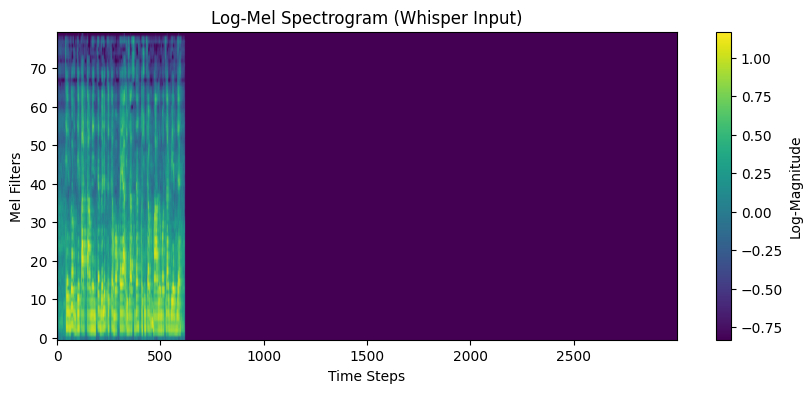

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Convert list to numpy array
spectrogram = np.array(sample["input_features"])

plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')
plt.title("Log-Mel Spectrogram (Whisper Input)")
plt.ylabel("Mel Filters")
plt.xlabel("Time Steps")
plt.colorbar(label="Log-Magnitude")
plt.show()

In [10]:
from scripts.whisper_utils import evaluate_by_dataset


def compute_metrics(pred):
    """
    Compute metrics using Uzbek text normalizer
    Reports both normalized and raw WER
    """
    results = evaluate_by_dataset(pred, processor, dataset["validation"])
    for ds_name, ds_metrics in results["by_dataset"].items():
        # Flatten by_dataset metrics with prefixes
        for metric_name, value in ds_metrics.items():
            # Simplify dataset breakdown metrics (keep only wer and wer_raw)
            if "wer" not in metric_name:
                continue
            results[f"{ds_name}_{metric_name}"] = value

    del results["by_dataset"]

    # Return corpus-level (macro-averaging), by dataset metrics
    return results

In [4]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # Split inputs and labels
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        # Pad input features
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # Pad labels
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # Replace padding with -100 to ignore loss
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # Remove BOS token if present
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch


data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [13]:
def train_model(model, processor, dataset):
    """
    Main training function

    Args:
        model: Whisper model
        processor: WhisperProcessor
        dataset: Prepared dataset

    Returns:
        Trained model
    """
    print("\n" + "=" * 50)
    print("TRAINING")
    print("=" * 50)

    # Define training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=os.path.join(OUTPUT_DIR, "whisper-uzbek-small"),  # Where to save the model

        # TODO: change for full dataset: save_steps, eval_steps, warmup_steps
        # Model checkpointing
        save_total_limit=4,  # Keep only 4 best checkpoints
        save_strategy="steps",
        save_steps=1750,  # Save checkpoint every 1750 steps (~ 2x per epoch)
        eval_strategy="steps",
        eval_steps=1750,  # Save checkpoint every 1750 steps (~ 2x per epoch)
        load_best_model_at_end=True,
        metric_for_best_model="wer",  # Primary metric
        greater_is_better=False,  # Lower WER is better

        # Batch size - optimized for A6000 48GB
        # Effective batch size = per_device_train_batch_size * gradient_accumulation_steps = 32
        per_device_train_batch_size=32,
        gradient_accumulation_steps=1,  # If you have smaller VRAM, you can simulate larger batch size
        per_device_eval_batch_size=128,  # Can be larger for eval (no gradients)

        # Learning rate and schedule
        learning_rate=1e-5,
        warmup_steps=1000,
        weight_decay=0.01,  # Add L2 regularization
        max_grad_norm=1.0,  # Gradient clipping

        # Training duration
        num_train_epochs=5,  # Number of times to go through dataset
        max_steps=-1,  # Train for full epochs

        # Memory optimization
        gradient_checkpointing=False,
        # Use gradient checkpointing to save memory at the expense of slower backward pass
        fp16=True,  # Use mixed precision for faster training
        fp16_full_eval=False,  # Use FP32 for eval (more stable)
        dataloader_num_workers=8,  # Parallel data loading
        dataloader_pin_memory=True,  # Faster GPU transfer

        # Generation settings
        predict_with_generate=True,  # Generate during eval
        generation_max_length=225,  # Token generation limit for a 30-second audio chunk
        generation_num_beams=1,
        # Model keeps track of n possible sentences at once (choose 1 for speed and less memory usage)

        # Logging
        logging_dir=LOGS_DIR,
        logging_steps=50,  # More frequent logging
        logging_strategy="steps",
        logging_first_step=True,
        report_to=["tensorboard"],

        push_to_hub=False,  # Set True to share on Hugging Face
        remove_unused_columns=False,  # Keep metadata columns
        seed=SEED,  # Use SEED for any random events
    )

    print("\n📊 Training Configuration:")
    print(f"  Output: {training_args.output_dir}")
    print(f"  Batch size: {training_args.per_device_train_batch_size}")
    print(f"  Gradient accumulation: {training_args.gradient_accumulation_steps}")
    print(
        f"  Effective batch size: {training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps}")
    print(f"  Learning rate: {training_args.learning_rate}")
    print(f"  Epochs: {training_args.num_train_epochs}")
    print(f"  FP16: {training_args.fp16}")
    print(f"  Gradient checkpointing: {training_args.gradient_checkpointing}")

    # Calculate training steps
    steps_per_epoch = len(dataset["train"]) // (
            training_args.per_device_train_batch_size *
            training_args.gradient_accumulation_steps
    )
    total_steps = steps_per_epoch * training_args.num_train_epochs

    print(f"\n📈 Training Schedule:")
    print(f"  Steps per epoch: {steps_per_epoch}")
    print(f"  Total steps: {total_steps}")
    print(f"  Warmup steps: {training_args.warmup_steps}")
    print(f"  Eval frequency: every {training_args.eval_steps} steps")
    print(f"  Save frequency: every {training_args.save_steps} steps")

    # Initialize data collator
    data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)
    print("✓ Initialized data collator")

    # Initialize trainer
    trainer = Seq2SeqTrainer(
        args=training_args,
        model=model,
        train_dataset=dataset["train"],
        eval_dataset=dataset["validation"],
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        processing_class=processor.feature_extractor,
    )
    print("✓ Initialized trainer")

    # Train
    print("\n🚀 Starting training...")
    print(f"Monitor: tensorboard --logdir {LOGS_DIR}\n")
    print("=" * 50)

    try:
        train_result = trainer.train()

        # Save final model
        trainer.save_model(FINAL_MODEL_PATH)
        processor.save_pretrained(FINAL_MODEL_PATH)

        print("\n" + "=" * 50)
        print("TRAINING COMPLETED!")
        print("=" * 50)
        print(f"Final metrics:")
        print(f"  Training loss: {train_result.training_loss:.4f}")
        print(f"  Training time: {train_result.metrics['train_runtime'] / 3600:.2f} hours")
        print(f"  Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")

        # Shows the highest amount of VRAM used since the script started
        peak_mem = torch.cuda.max_memory_allocated(device) / 1e9
        print(f"\nPeak GPU memory usage: {peak_mem:.2f} GB")

        return model, trainer

    except KeyboardInterrupt:
        print("\n\nTraining interrupted by user!")
        print("Saving checkpoint...")
        trainer.save_model(os.path.join(OUTPUT_DIR, "interrupted_checkpoint"))
        raise
    except Exception as e:
        print(f"\n\nError during training: {e}")
        raise


model, trainer = train_model(model, processor, dataset)


TRAINING

📊 Training Configuration:
  Output: ../outputs/part1/whisper-uzbek-small
  Batch size: 32
  Gradient accumulation: 1
  Effective batch size: 32
  Learning rate: 1e-05
  Epochs: 5
  FP16: True
  Gradient checkpointing: False

📈 Training Schedule:
  Steps per epoch: 3493
  Total steps: 17465
  Warmup steps: 1000
  Eval frequency: every 1750 steps
  Save frequency: every 1750 steps
✓ Initialized data collator
✓ Initialized trainer

🚀 Starting training...
Monitor: tensorboard --logdir /root/uzbek-automatic-speech-recognition/outputs/part1/logs



You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize

Step,Training Loss,Validation Loss,Wer,Cer,Sequence Similarity,Wer Raw,Cer Raw,Sequence Similarity Raw,Uzbek Voice Wer,Uzbek Voice Wer Raw,Common Voice Wer,Common Voice Wer Raw,Feruza Speech Wer,Feruza Speech Wer Raw,News Wer,News Wer Raw,It Wer,It Wer Raw
1750,0.247800,0.204780,0.166800,0.042200,0.917400,0.215400,0.049900,0.905500,0.131300,0.167500,0.163700,0.210200,0.133300,0.210000,0.263800,0.344600,0.293600,0.370700
3500,0.176800,0.145534,0.118000,0.030400,0.935300,0.163000,0.037400,0.919000,0.086900,0.120300,0.106500,0.150500,0.109400,0.189000,0.204200,0.277600,0.230500,0.300500
5250,0.121000,0.130458,0.101800,0.026500,0.943000,0.145500,0.033200,0.928800,0.071100,0.103200,0.097900,0.140400,0.088000,0.162600,0.183100,0.256600,0.211600,0.278900
7000,0.099300,0.119360,0.095000,0.025700,0.944100,0.137200,0.032400,0.931500,0.063000,0.093300,0.087900,0.128700,0.086500,0.154600,0.185100,0.259500,0.201800,0.269100
8750,0.067800,0.118196,0.091000,0.024600,0.946400,0.133100,0.031100,0.932700,0.060300,0.090800,0.083000,0.124700,0.075100,0.144100,0.184700,0.253700,0.187100,0.259500
10500,0.053600,0.115617,0.086100,0.023100,0.947800,0.127100,0.029400,0.936900,0.057700,0.086900,0.081100,0.122500,0.065100,0.138700,0.160900,0.230000,0.193300,0.259100
12250,0.031800,0.120147,0.086000,0.023300,0.946600,0.127500,0.029700,0.933200,0.057000,0.088000,0.080400,0.119400,0.067100,0.137200,0.167600,0.234200,0.187100,0.254700
14000,0.023300,0.120137,0.083900,0.022500,0.947200,0.124700,0.028800,0.937100,0.055500,0.085500,0.078400,0.117500,0.069600,0.139200,0.160800,0.225600,0.185800,0.255500
15750,0.016200,0.125820,0.085300,0.023000,0.948300,0.125900,0.029200,0.936100,0.056500,0.086500,0.079900,0.116000,0.069600,0.140100,0.164100,0.230900,0.188100,0.254900


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize


TRAINING COMPLETED!
Final metrics:
  Training loss: 0.1418
  Training time: 4.95 hours
  Samples per second: 31.37

Peak GPU memory usage: 36.38 GB


In [6]:
from scripts.whisper_utils import load_model, evaluate_by_dataset_with_trainer

final_model, final_trainer, final_processor = load_model(FINAL_MODEL_PATH, dataset, data_collator, eval_batch_size=128)
evaluate_by_dataset_with_trainer(final_trainer, final_processor, dataset["validation"], "validation")
evaluate_by_dataset_with_trainer(final_trainer, final_processor, dataset["test"], "test")

del final_model, final_trainer, final_processor
gc.collect()

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize


DETAILED EVALUATION: VALIDATION

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)               8.38%
CER (normalized)               2.25%
Sequence Similarity           94.73%
WER (raw)                     12.46%
CER (raw)                      2.88%
Seq Similarity (raw)          93.72%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)               7.84%
CER (normalized)               1.75%
Sequence Similarity           98.72%
WER (raw)                     11.75%
CER (raw)                      2.35%
Seq Similarity (raw)          98.28%

feruza_speech
--------------------------------------------------------------------------------
WER (normalized)               7.01%
CER (normalized)               1.22%
Sequence Similarity           96.74%
WER (raw)                     13.97%
CER (raw)                      2.43%
Seq Similarity (raw)         

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize


DETAILED EVALUATION: TEST

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)               8.63%
CER (normalized)               2.39%
Sequence Similarity           95.06%
WER (raw)                     12.98%
CER (raw)                      3.10%
Seq Similarity (raw)          93.50%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)               9.28%
CER (normalized)               2.20%
Sequence Similarity           98.37%
WER (raw)                     13.76%
CER (raw)                      2.88%
Seq Similarity (raw)          97.86%

feruza_speech
--------------------------------------------------------------------------------
WER (normalized)               7.86%
CER (normalized)               1.41%
Sequence Similarity           95.45%
WER (raw)                     14.68%
CER (raw)                      2.46%
Seq Similarity (raw)          94.55

{'wer': 0.0863,
 'cer': 0.0239,
 'sequence_similarity': 0.9506,
 'wer_raw': 0.1298,
 'cer_raw': 0.031,
 'sequence_similarity_raw': 0.935,
 'by_dataset': {'uzbek_voice': {'wer': 0.0546,
   'cer': 0.0123,
   'sequence_similarity': 0.9909,
   'wer_raw': 0.0836,
   'cer_raw': 0.0167,
   'sequence_similarity_raw': 0.9876},
  'common_voice': {'wer': 0.0928,
   'cer': 0.022,
   'sequence_similarity': 0.9837,
   'wer_raw': 0.1376,
   'cer_raw': 0.0288,
   'sequence_similarity_raw': 0.9786},
  'feruza_speech': {'wer': 0.0786,
   'cer': 0.0141,
   'sequence_similarity': 0.9545,
   'wer_raw': 0.1468,
   'cer_raw': 0.0246,
   'sequence_similarity_raw': 0.9455},
  'news': {'wer': 0.1602,
   'cer': 0.0574,
   'sequence_similarity': 0.8075,
   'wer_raw': 0.2351,
   'cer_raw': 0.0714,
   'sequence_similarity_raw': 0.7492},
  'it': {'wer': 0.1621,
   'cer': 0.0627,
   'sequence_similarity': 0.8032,
   'wer_raw': 0.2288,
   'cer_raw': 0.0744,
   'sequence_similarity_raw': 0.7447}}}

In [6]:
from scripts.whisper_utils import load_checkpoint, evaluate_by_dataset_with_trainer

check_17470_model, check_17470_trainer, check_17470_processor = load_checkpoint(
    os.path.join(MODEL_CHECKPOINTS_PATH, "checkpoint-17470"),
    dataset,
    data_collator,
    base_model_name="openai/whisper-small",
    eval_batch_size=128
)
evaluate_by_dataset_with_trainer(check_17470_trainer, check_17470_processor, dataset["validation"], "validation")
evaluate_by_dataset_with_trainer(check_17470_trainer, check_17470_processor, dataset["test"], "test")

del check_17470_model, check_17470_trainer, check_17470_processor
gc.collect()

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize


DETAILED EVALUATION: VALIDATION

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)               8.50%
CER (normalized)               2.30%
Sequence Similarity           94.74%
WER (raw)                     12.55%
CER (raw)                      2.92%
Seq Similarity (raw)          93.63%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)               7.86%
CER (normalized)               1.77%
Sequence Similarity           98.71%
WER (raw)                     11.63%
CER (raw)                      2.34%
Seq Similarity (raw)          98.29%

feruza_speech
--------------------------------------------------------------------------------
WER (normalized)               6.96%
CER (normalized)               1.11%
Sequence Similarity           97.04%
WER (raw)                     14.06%
CER (raw)                      2.37%
Seq Similarity (raw)         

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize


DETAILED EVALUATION: TEST

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)               8.66%
CER (normalized)               2.43%
Sequence Similarity           95.13%
WER (raw)                     12.98%
CER (raw)                      3.14%
Seq Similarity (raw)          93.50%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)               9.23%
CER (normalized)               2.19%
Sequence Similarity           98.37%
WER (raw)                     13.67%
CER (raw)                      2.89%
Seq Similarity (raw)          97.85%

feruza_speech
--------------------------------------------------------------------------------
WER (normalized)               7.76%
CER (normalized)               1.33%
Sequence Similarity           95.76%
WER (raw)                     13.69%
CER (raw)                      2.26%
Seq Similarity (raw)          94.90

5744

In [7]:
def test_model(model_path: str, audio_file: str):
    """
    Test the fine-tuned model on a sample audio file

    Args:
        model_path: Path to fine-tuned model
        audio_file: Path to audio file to transcribe
    """
    print("\n" + "=" * 50)
    print("TESTING MODEL")
    print("=" * 50)

    from transformers import pipeline

    # Load model
    pipe = pipeline(
        "automatic-speech-recognition",
        model=model_path,
        device=0 if torch.cuda.is_available() else -1
    )

    print(f"✓ Loaded model from {model_path}")
    print(f"✓ Processing: {audio_file}")

    # Transcribe
    result = pipe(audio_file, language="uz", task="transcribe")

    print(f"\nTranscription: {result['text']}")

    return result


test_audio = os.path.join(DATASET_DIR, "devona_sample.wav")
if os.path.exists(test_audio):
    test_model(FINAL_MODEL_PATH, test_audio)


TESTING MODEL


Device set to use cuda:0
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.


✓ Loaded model from /root/uzbek-automatic-speech-recognition/outputs/part1/whisper-uzbek-final
✓ Processing: ../datasets/devona_sample.wav

Transcription: Har kuni ertalab quyosh chiqayotganida uydan chiqargan. Oldin eshik oldida turib atrofga uzoq tikilar. Keyin qo'llarini, ko'zlarini va qalbini samoga yo'naltirib, Vodud, yo Vodud deb baqirardi.


⚠️ I discovered that I sampled **News** dataset's validation and test sets in a biased way, covering only samples with 0 < WER <= 20 (predicted by Google STT against Gemini 2.5 Pro). After adding additional ~25 minutes of test set with WER > 20% samples, re-evaluate this part 1 final model again using dataset from part 2.

Note: Validation and test sets of News and IT datasets are all manually checked.

In [10]:
from scripts.whisper_utils import load_model, evaluate_by_dataset_with_trainer
from datasets import load_from_disk

PART2_DATASET_PATH = os.path.abspath(os.path.join("../outputs/part2/processed_uzbek_asr_dataset"))
splits = ["test", "validation"]
dataset = DatasetDict({
    split: load_from_disk(os.path.join(PART2_DATASET_PATH, split))
    for split in splits
})

final_model, final_trainer, final_processor = load_model(FINAL_MODEL_PATH, dataset, data_collator, eval_batch_size=128)
evaluate_by_dataset_with_trainer(final_trainer, final_processor, dataset["test"], "test")

Loading dataset from disk:   0%|          | 0/17 [00:00<?, ?it/s]

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenize


DETAILED EVALUATION: TEST

OVERALL METRICS
--------------------------------------------------------------------------------
WER (normalized)               9.63%
CER (normalized)               2.89%
Sequence Similarity           94.08%
WER (raw)                     14.13%
CER (raw)                      3.64%
Seq Similarity (raw)          92.31%

METRICS BY DATASET

common_voice
--------------------------------------------------------------------------------
WER (normalized)               9.29%
CER (normalized)               2.20%
Sequence Similarity           98.36%
WER (raw)                     13.78%
CER (raw)                      2.88%
Seq Similarity (raw)          97.86%

it
--------------------------------------------------------------------------------
WER (normalized)              16.28%
CER (normalized)               6.29%
Sequence Similarity           80.19%
WER (raw)                     22.93%
CER (raw)                      7.47%
Seq Similarity (raw)          74.48%

news
---

{'wer': 0.0963,
 'cer': 0.0289,
 'sequence_similarity': 0.9408,
 'wer_raw': 0.1413,
 'cer_raw': 0.0364,
 'sequence_similarity_raw': 0.9231,
 'by_dataset': {'uzbek_voice': {'wer': 0.0547,
   'cer': 0.0123,
   'sequence_similarity': 0.9909,
   'wer_raw': 0.0837,
   'cer_raw': 0.0167,
   'sequence_similarity_raw': 0.9876},
  'news': {'wer': 0.1981,
   'cer': 0.0777,
   'sequence_similarity': 0.7812,
   'wer_raw': 0.2781,
   'cer_raw': 0.0932,
   'sequence_similarity_raw': 0.7212},
  'common_voice': {'wer': 0.0929,
   'cer': 0.022,
   'sequence_similarity': 0.9836,
   'wer_raw': 0.1378,
   'cer_raw': 0.0288,
   'sequence_similarity_raw': 0.9786},
  'it': {'wer': 0.1628,
   'cer': 0.0629,
   'sequence_similarity': 0.8019,
   'wer_raw': 0.2293,
   'cer_raw': 0.0747,
   'sequence_similarity_raw': 0.7448}}}